In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sc

In [2]:
datapath = "/home/haue/repositories/Masters/data/pad_calibration/"
ch_file = datapath+"padmatcher_peaks.txt"
cal_file = datapath+"padcalc_peaks.txt"

In [ ]:
dtype = [('detector', 'U10'), ('channel', 'i4'), ('xvalue', 'i4'), ('sigma', 'f8')]

ch_data = np.genfromtxt(ch_file, dtype=dtype, encoding=None)
cal_data = np.genfromtxt(cal_file, dtype=dtype, encoding=None)
# Access each column using field names:

ch_means = ch_data['xvalue']
ch_sigmas = ch_data['sigma']
cal_means = cal_data['xvalue']
cal_sigmas = cal_data['sigma']

nrpeaks = 4

def lin(x, a, b):
    return a*x+b

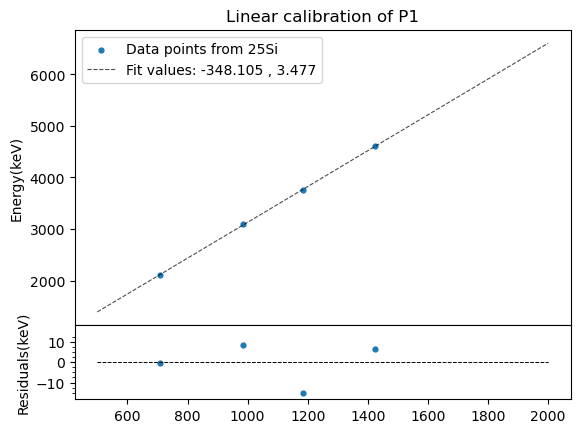

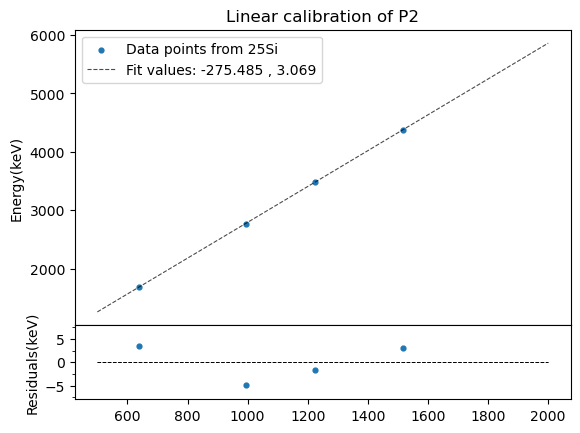

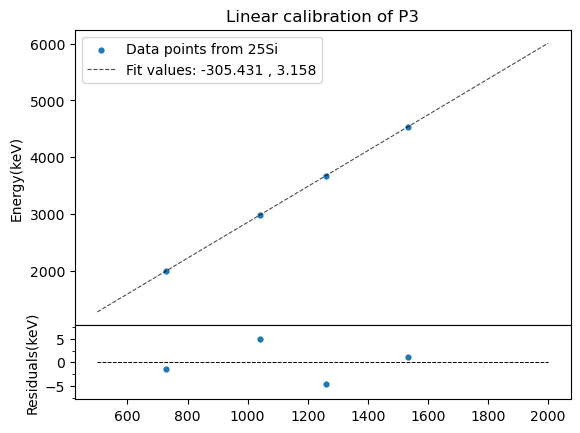

In [ ]:
for i in range(1,5):
    ch_x = ch_means[nrpeaks*(i-1):nrpeaks*i]
    cal_x = cal_means[nrpeaks*(i-1):nrpeaks*i]
    pad = f"P{i}"
    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0}, sharex=True)
    ax1, ax2 = axs
    
    popt, _ = sc.curve_fit(lin, ch_x, cal_x)
    
    xs = np.linspace(500, 2000)
    fitvals = lin(ch_x, popt[0], popt[1])
    resi = cal_x-fitvals
    ax1.scatter(ch_x, cal_x, s=12, label="Data points from 25Si")
    ax1.plot(xs,lin(xs, popt[0], popt[1]), ls='--',color='k', alpha=0.7, lw=0.8,label=f"Fit values: {np.round(popt[1], 3)} , {np.round(popt[0], 3)}")
    ax1.set_xlabel("Channel")
    ax1.set_ylabel("Energy(keV)")
    if i==4:
        pad = "P6"
    ax1.set_title(f"Linear calibration of {pad}")
    ax1.legend()
    
    ax2.hlines(0, 500,2000, color='grey', ls='--', lw=0.7)
    ax2.scatter(ch_x, resi, s=12)
    #ax2.legend(fontsize='x-small', loc='lower right')
    ax2.hlines(0, 500, 2000, ls='--', color='k', lw=0.7) 
    ax2.set_yticks(np.arange(-15,15,2.5), minor=True)
    ax2.set_ylim(-np.max(np.abs(resi))-3, np.max(np.abs(resi))+3)
    ax2.set_ylabel("Residuals(keV)")
    